In [1]:
import cv2
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
import xlsxwriter
import keyboard
# Path to Tesseract.exe
pytesseract.pytesseract.tesseract_cmd = r''

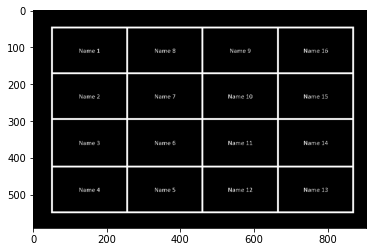

In [2]:
#read your file
file=r''
img = cv2.imread(file,0)
img.shape
#thresholding the image to a binary image
thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
#inverting the image 
img_bin = 255-img_bin
cv2.imwrite('test1_inv.png',img_bin)
#Plotting the image to see the output
plotting = plt.imshow(img_bin,cmap='gray')
plt.show()

In [3]:
# Length(width) of kernel as 100th of total width
kernel_len = np.array(img).shape[1]//100
# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

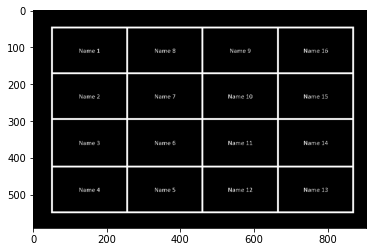

In [4]:
#read your file
file=r''
img = cv2.imread(file,0)
img.shape
#thresholding the image to a binary image
thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
#inverting the image 
img_bin = 255-img_bin
cv2.imwrite('test_inv.png',img_bin)
#Plotting the image to see the output
plotting = plt.imshow(img_bin,cmap='gray')
plt.show()

In [5]:
# Length(width) of kernel as 100th of total width
kernel_len = np.array(img).shape[1]//100
# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

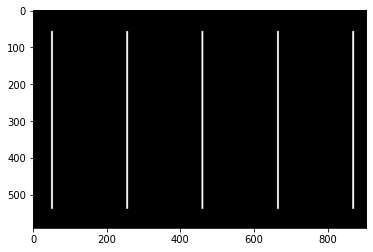

In [6]:
#Use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
cv2.imwrite("image_vertical.jpg",vertical_lines)
#Plot the generated image
plotting = plt.imshow(image_1,cmap='gray')
plt.show()

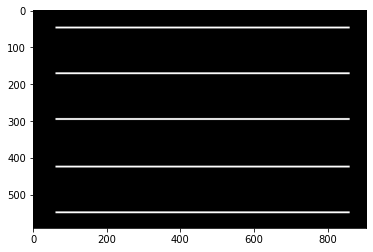

In [7]:
#Use horizontal kernel to detect and save the horizontal lines in a jpg
image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
cv2.imwrite("test_horizontal.jpg",horizontal_lines)
#Plot the generated image
plotting = plt.imshow(image_2,cmap='gray')
plt.show()

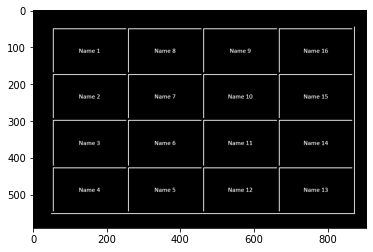

In [8]:
# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
#Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite("test_grid.jpg", img_vh)
bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)
#Plotting the generated image
plotting = plt.imshow(bitnot,cmap='Greys')
plt.show()

In [9]:
# Detect contours for following box detection
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [10]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == 'right-to-left' or method == 'bottom-to-top':
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == 'top-to-bottom' or method == 'bottom-to-top':
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
        boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours, method='top-to-bottom')

In [11]:
#Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
#Get mean of heights
mean = np.mean(heights)

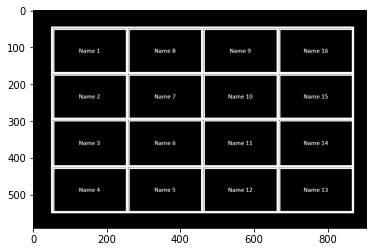

In [12]:
#Create list box to store all boxes in  
box = []
# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
plotting = plt.imshow(image,cmap="Greys")
plt.show()

In [13]:
#Creating two lists to define row and column in which cell is located
row=[]
column=[]
j=0
#Sorting the boxes to their respective row and column
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
print(column)
print(row)

[[669, 429, 197, 117], [464, 429, 198, 117], [260, 429, 197, 117], [56, 429, 197, 117]]
[[[669, 52, 197, 117], [464, 52, 198, 117], [260, 52, 197, 117], [56, 52, 197, 117]], [[669, 176, 197, 117], [464, 176, 198, 117], [260, 176, 197, 117], [56, 176, 197, 117]], [[669, 300, 197, 122], [464, 300, 198, 122], [260, 300, 197, 122], [56, 300, 197, 122]], [[669, 429, 197, 117], [464, 429, 198, 117], [260, 429, 197, 117], [56, 429, 197, 117]]]


In [14]:
#calculating maximum number of cells
countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

In [15]:
#Retrieving the center of each column
center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

In [16]:
#Regarding the distance to the columns center, the boxes are arranged in respective order
finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)

In [17]:
#from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)

In [18]:
#Creating a dataframe of the generated OCR list
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row), countcol))
print(dataframe)
print("Ready to Convert the Img File\n Do you want a csv file or excel file?\n "
      "\tPress [x] for Excel.\n"
      "\tPress [c] for csv.\n")
while True:
    if keyboard.read_key() == "x":

        data = dataframe.replace(r'\n', '', regex=True)
        data = data.style.set_properties(align="left")
        # Converting it in a excel-file
        ILLEGAL_CHARACTERS_RE = re.compile(r'[\000-\010]|[\013-\014]|[\016-\037]')
        data = data.applymap(lambda x: ILLEGAL_CHARACTERS_RE.sub(r'', x) if isinstance(x, str) else x)
        # Converting it in a excel-file
        print(data)
        # Change the Path to the destination
        writer = pd.ExcelWriter(file+'excel.xlsx',
                                engine='xlsxwriter',
                                options={'strings_to_numbers': True},
                                )
        data.to_excel(writer, encoding="utf-8")
        writer.save()
        print("Thank You\n")
        break
    elif keyboard.read_key() == "c":
        data = dataframe.replace(r'\n', '', regex=True)
        # Converting it in a excel-file
        ILLEGAL_CHARACTERS_RE = re.compile(r'[\000-\010]|[\013-\014]|[\016-\037]')
        data = data.applymap(lambda x: ILLEGAL_CHARACTERS_RE.sub(r'', x) if isinstance(x, str) else x)
        # Converting it in a excel-file
        print(data)
        # Change the Path to the destination
        data.to_csv(file+'csv.csv', encoding="utf-8")
        print("Thank You\n")
        break
    else:
        print("Nothing!!!\n")
        break

            0           1            2            3
0   Name 1\n   Name 8\n    Name 9\n   Name 16\n
1   Name 2\n   Name 7\n   Name 10\n   Name 15\n
2   Name 3\n   Name 6\n   Name 11\n   Name 14\n
3   Name 4\n   Name 5\n   Name 12\n   Name 13\n


c:\users\asus\rotten-scripts\lib\site-packages\pandas\io\formats\css.py:261: CSSWarning: Ill-formatted attribute: expected a colon in ' Name 1\n'
  warnings.warn(
c:\users\asus\rotten-scripts\lib\site-packages\pandas\io\formats\css.py:261: CSSWarning: Ill-formatted attribute: expected a colon in ' Name 2\n'
  warnings.warn(
c:\users\asus\rotten-scripts\lib\site-packages\pandas\io\formats\css.py:261: CSSWarning: Ill-formatted attribute: expected a colon in ' Name 3\n'
  warnings.warn(
c:\users\asus\rotten-scripts\lib\site-packages\pandas\io\formats\css.py:261: CSSWarning: Ill-formatted attribute: expected a colon in ' Name 4\n'
  warnings.warn(
c:\users\asus\rotten-scripts\lib\site-packages\pandas\io\formats\css.py:261: CSSWarning: Ill-formatted attribute: expected a colon in ' Name 8\n'
  warnings.warn(
c:\users\asus\rotten-scripts\lib\site-packages\pandas\io\formats\css.py:261: CSSWarning: Ill-formatted attribute: expected a colon in ' Name 7\n'
  warnings.warn(
c:\users\asus\rotten-s